In [1]:
# temporary fix to avoid spurious warning raised in scikit-learn 1.0.0
# it will be solved in scikit-learn 1.0.1
import warnings
warnings.filterwarnings("ignore", message="X has feature names.*")
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

In [2]:
import pandas as pd

data = pd.read_csv("../datasets/penguins_classification.csv")
target_name = "Species"
X = data.drop(columns=target_name)
y = data[target_name]

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)
X_train.head()

,Culmen Length (mm),Culmen Depth (mm)
306,42.5,16.7
101,37.7,16.0
153,48.7,14.1
341,50.2,18.7
81,36.7,18.8


In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9767441860465116

In [5]:
model.n_iter_

array([74], dtype=int32)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.head()

,Culmen Length (mm),Culmen Depth (mm)
0,-0.296655,-0.179780
1,-1.177588,-0.542581
2,0.841216,-1.527324
3,1.116508,0.856792
4,-1.361115,0.908620


In [10]:
X_train.mean(), X_train_scaled.mean()

(Culmen Length (mm)    44.116406
 Culmen Depth (mm)     17.046875
 dtype: float64,
 Culmen Length (mm)    5.620504e-16
 Culmen Depth (mm)     5.898060e-17
 dtype: float64)

In [11]:
X_train.std(), X_train_scaled.std()

(Culmen Length (mm)    5.459444
 Culmen Depth (mm)     1.933216
 dtype: float64,
 Culmen Length (mm)    1.001959
 Culmen Depth (mm)     1.001959
 dtype: float64)

In [12]:
model.fit(X_train_scaled, y_train)
model.n_iter_

array([14], dtype=int32)

In [13]:
X_test_scaled = scaler.transform(X_test)
model.score(X_test_scaled, y_test)

0.9883720930232558

In [14]:
import sklearn

sklearn.set_config(display="diagram")

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [16]:
model.score(X_test, y_test)

0.9883720930232558

In [17]:
model[-1].n_iter_

array([14], dtype=int32)

In [18]:
data = pd.read_csv("../datasets/adult-census-numeric-all.csv")
data.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,class
0,25,7,0,0,40,<=50K
1,38,9,0,0,50,<=50K
2,28,12,0,0,40,>50K
3,44,10,7688,0,40,>50K
4,18,10,0,0,30,<=50K


In [19]:
target_name = "class"
X = data.drop(columns=target_name)
y = data[target_name]

In [20]:
model = LogisticRegression(max_iter=50)
model.fit(X, y)

/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=50)

In [21]:
model.set_params(max_iter=1_000)
model.fit(X, y)

LogisticRegression(max_iter=1000)

In [22]:
model.n_iter_

array([100], dtype=int32)

In [23]:
import seaborn as sns
sns.set_context("poster")

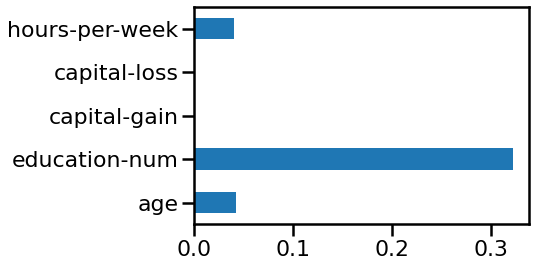

In [24]:
coef = pd.Series(model.coef_[0], index=X.columns)
_ = coef.plot.barh()

In [25]:
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [26]:
model[-1].n_iter_

array([13], dtype=int32)

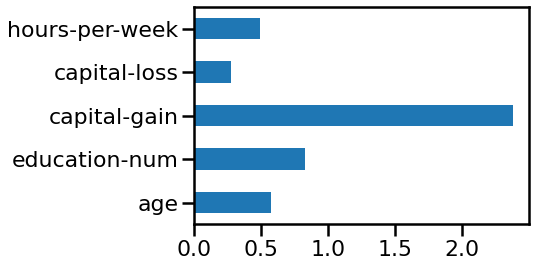

In [27]:
coef = pd.Series(model[-1].coef_[0], index=X.columns)
_ = coef.plot.barh()